# Model deployment

One of the main goals of PyMC-Marketing is to facilitate the deployment of its models. 

This is achieved by building our models on top of [ModelBuilder](https://www.pymc.io/projects/examples/en/latest/howto/model_builder.html), a brand new [PyMC experimental](https://www.pymc.io/projects/experimental/en/latest/) feature that offers a scikit-learn-like API and makes PyMC models easy to deploy.

PyMC-marketing models inherit 2 easy-to-use methods: `save` and `load` that can be used after the model has been fitted. All models can be configured with two standard dictionaries: `model_config` and `sampler_config` that are serialized during `save` and persisted after `load`, allowing model reuse across workflows.

We will illustrate this functionality with the example model described in the [MMM Example Notebook](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html). For sake of generality, we ommit most technical details here.

In [1]:
import arviz as az
import numpy as np
import pandas as pd

from pymc_marketing.mmm import DelayedSaturatedMMM

In [2]:
seed = sum(map(ord, "mmm"))
rng = np.random.default_rng(seed=seed)

Let's load the dataset:

In [3]:
url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
df = pd.read_csv(url)

columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()
data["t"] = np.arange(df.shape[0])
data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4


But for our model we need much smaller dataset, many of the previous features were contributing to generation of others, now as our target variable is computed we can filter out not needed columns:

## Model and sampling configuration

### Model configuration

We first illustrate the use of `model_config` to define custom priors within the model.

Because there are potentially many variables that can be configured, each model provides a `default_model_config` attribute. This will allow you to see which settings are available by default and only define the ones you need to change.

We need to create a dummy model to be able to see the configuration dictionary.

In [4]:
dummy_model = DelayedSaturatedMMM(
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)
dummy_model.default_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

We can change the parameters that go into the distribution of each term.
In this case we'll just simply replace the `sigma` for `beta_channel` with a custom one:

In [5]:
n_channels = 2

total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()
spend_share

# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()
prior_sigma

array([2.1775326 , 1.14026088])

In [6]:
my_model_config = {'beta_channel': {'sigma': prior_sigma, 'dims': ('channel',)}}

As mentioned in the original notebook: _"For the prior specification there is no right or wrong answer. It all depends on the data, the context and the assumptions you are willing to make. It is always recommended to do some prior predictive sampling and sensitivity analysis to check the impact of the priors on the posterior. We skip this here for the sake of simplicity. If you are not sure about specific priors, the `DelayedSaturatedMMM` class has some default priors that you can use as a starting point."_

### Sampling  configuration

The second feature we can customize is `sampler_config`. Similar to `model_config`, it's a dictionary that gets saved and contains things you would usually pass to the `fit()` kwargs. It's not mandatory to create your own `sampler_config`. The default `DelayedSaturatedMMM.sampler_config` is empty because the default sampling parameters usually prove sufficient for a start.

In [7]:
dummy_model.default_sampler_config

{}

In [8]:
my_sampler_config = {
    'tune':1000,
    'draws':1000,
    'chains':4,
    'target_accept':0.95,
}

Let's finally assemble our model!

In [9]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = my_sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

We can confirm our settings are being used

In [10]:
mmm.model_config["beta_channel"]

{'sigma': array([2.1775326 , 1.14026088]), 'dims': ('channel',)}

In [11]:
mmm.sampler_config

{'tune': 1000, 'draws': 1000, 'chains': 4, 'target_accept': 0.95}

## Model Fitting

Note that we didn't pass the dataset to the class constructor itself. This is done to mimick the `scikit-learn` API, and make it easier to get started on PyMC-Marketing models.

In [12]:
# Split X, and y
X = data.drop('y',axis=1)
y = data['y']

All that's left now is to finally fit the model:

As you can see below, you can still pass the sampler kwargs directly to `fit()` method. However, only those kwargs passed using `sampler_config` will be saved and reused after loading the model.

In [13]:
mmm.fit(X=X, y=y, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
Sampling: [alpha, beta_channel, gamma_control, gamma_fourier, intercept, lam, likelihood, sigma]
Sampling: [likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

The `fit()` method automatically builds the model using the priors from `model_config`, and assigns the created model to our instance. You can access it as a normal attribute.

In [14]:
type(mmm.model)

pymc.model.Model

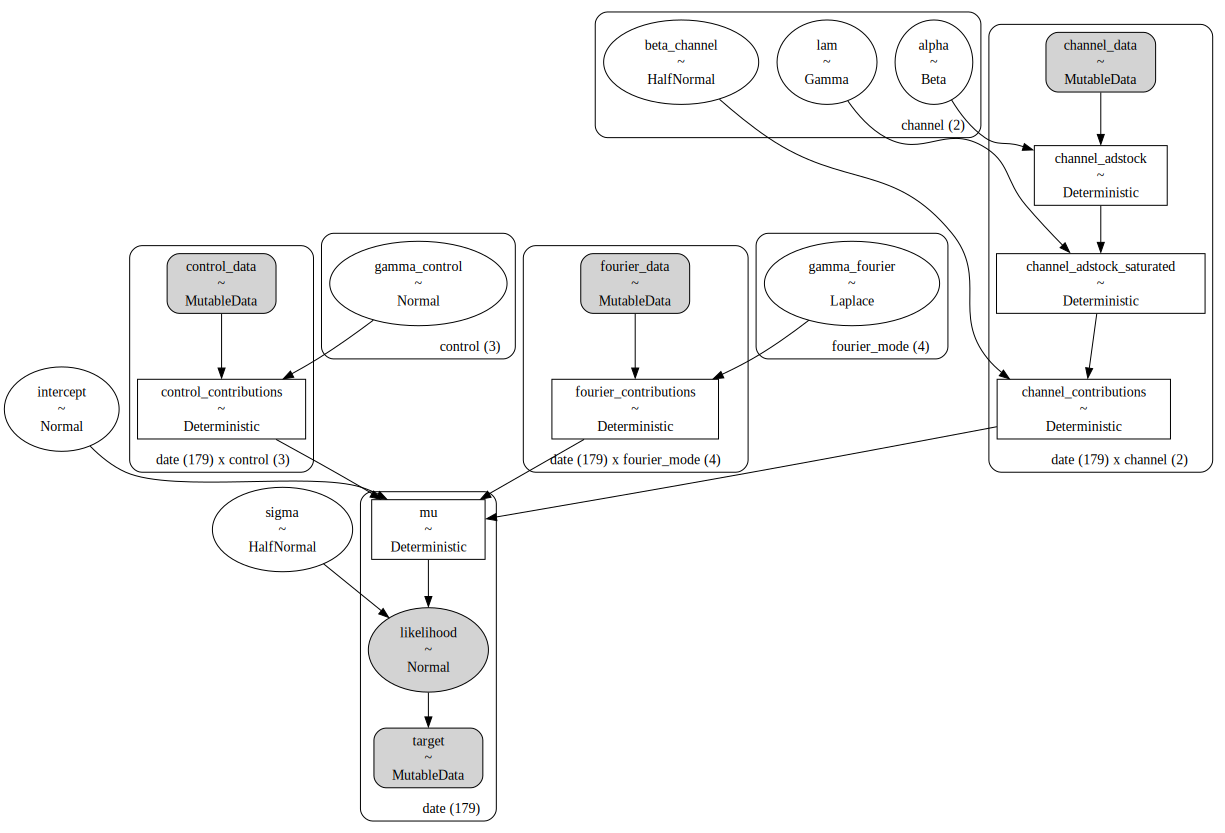

In [15]:
mmm.graphviz()

posterior trace can be accessed by `fit_result` attribute

In [16]:
mmm.fit_result

<xarray.Dataset>
Dimensions:                    (chain: 4, draw: 1000, control: 3,
                                fourier_mode: 4, channel: 2, date: 179)
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * control                    (control) <U7 'event_1' 'event_2' 't'
  * fourier_mode               (fourier_mode) <U11 'sin_order_1' ... 'cos_ord...
  * channel                    (channel) <U2 'x1' 'x2'
  * date                       (date) <U10 '2018-04-02' ... '2021-08-30'
Data variables: (12/13)
    intercept                  (chain, draw) float64 0.3852 0.3278 ... 0.311
    gamma_control              (chain, draw, control) float64 0.2353 ... 0.00...
    gamma_fourier              (chain, draw, fourier_mode) float64 0.004958 ....
    beta_channel               (chain, draw, channel) float64 0.3975 ... 0.3032
    alpha                      (chain, draw, channel) float64 0.4327 ... 0.2364
    lam                        (chain, draw, channel) float64 2.864 ... 2.357
    ...                         ...
    channel_adstock            (chain, draw, date, channel) float64 0.1816 .....
    channel_adstock_saturated  (chain, draw, date, channel) float64 0.2543 .....
    channel_contributions      (chain, draw, date, channel) float64 0.1011 .....
    control_contributions      (chain, draw, date, control) float64 0.0 ... 0...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 0.00...
    mu                         (chain, draw, date) float64 0.4922 ... 0.6067
Attributes:
    created_at:                 2023-08-03T12:44:52.592010
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.0
    sampling_time:              71.22048568725586
    tuning_steps:               1000

If you wish to inspect the entire inference data, use the `idata` attribute. Within `idata`, you can find the entire dataset passed to the model under `fit_data`.

In [17]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

## Saving and loading a fitted model

All the data passed to the model on initialization is stored in `idata.attrs`. This will be used later in the `save()` method to convert both this data and all the fit data into the netCDF format. You can read more about this format [here](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html).

The `save` and `load` method only require a path to inform where the model should be saved and loaded from.

In [18]:
mmm.save('my_saved_model.nc')

In [19]:
loaded_model = DelayedSaturatedMMM.load('my_saved_model.nc')

/home/ricardo/miniconda3/envs/pymc-marketing/lib/python3.11/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [20]:
loaded_model.model_config["beta_channel"]

{'sigma': array([2.1775326 , 1.14026088]), 'dims': ('channel',)}

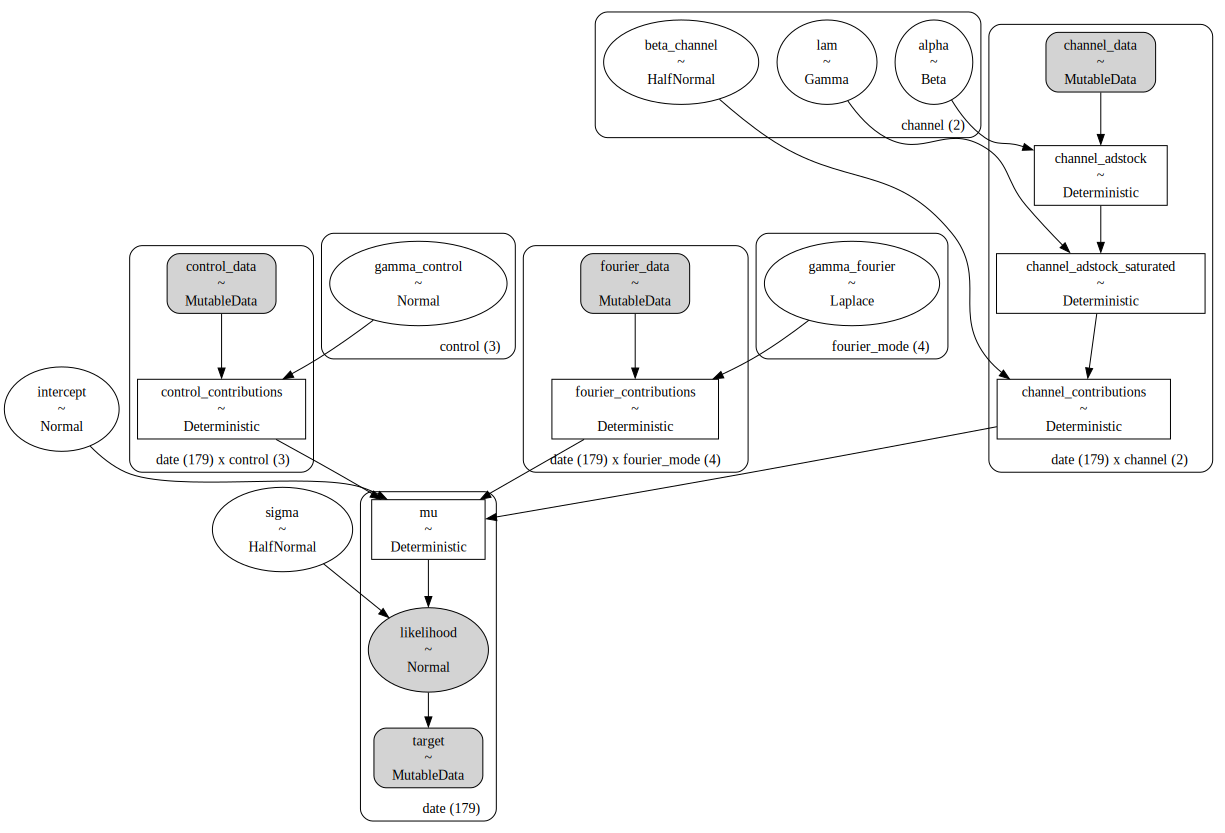

In [21]:
loaded_model.graphviz()

In [22]:
loaded_model.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

A loaded model is ready to be used for sampling and prediction, making use of the previous fitting results and data if needed.

In [23]:
loaded_model.sample_posterior_predictive(X, extend_idata=True, combined=False, random_seed=rng)

Sampling: [likelihood]


<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, date: 179)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * date        (date) <U10 '2018-04-02' '2018-04-09' ... '2021-08-30'
Data variables:
    likelihood  (chain, draw, date) float64 0.5057 0.4536 ... 0.5621 0.5581
Attributes:
    created_at:                 2023-08-03T12:45:03.555645
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.0

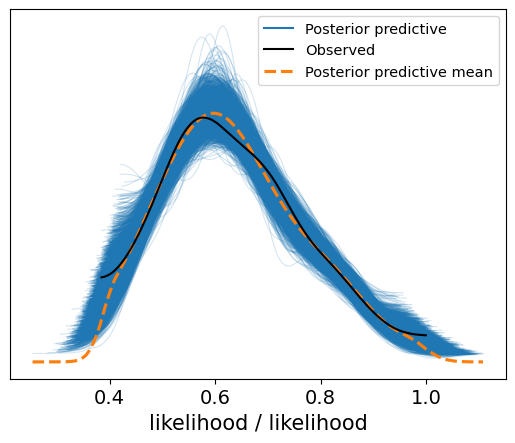

In [24]:
az.plot_ppc(loaded_model.idata);

## Other models

Even though this introduction is using `DelayedSaturatedMMM`, all other PyMC-Marketing models (MMM and CLV) provide these functionalities as well.

## Summary

The PyMC-Marketing functionalities described here are intended to facilitate model sharing among data science teams without demanding extensive modelling technical knowledge for everyone involved. We are still iterating on our API and would love to hear more feedback from our users!